
```
# Mortgage Credit Risk Modeling - Notebook 04: Exploratory Data Analysis

**Course**: Advanced Econometrics and Financial Risk Management  
**Assignment**: Capstone Project - Credit Risk Modeling  
**Date**: March 2025  
**Author**: Vanessa Quintero

---

## Learning Objectives

By completing this notebook, you will be able to:

1. **Conduct Comprehensive Univariate Analysis**: Examine individual feature distributions, identify outliers, and assess data characteristics that impact credit risk model performance

2. **Perform Advanced Bivariate Analysis**: Analyze relationships between risk factors and default outcomes using statistical tests and visualization techniques employed by financial institutions

3. **Apply Credit Risk Segmentation**: Create and validate risk-based portfolio segments using industry-standard methodologies for credit score, LTV, and DTI categories

4. **Analyze Economic and Geographic Factors**: Evaluate the impact of economic cycles, geographic concentration, and market conditions on default rates following regulatory stress testing frameworks

5. **Identify Key Risk Drivers**: Determine primary and secondary risk factors through correlation analysis, feature importance assessment, and business logic validation

6. **Generate Portfolio Insights**: Develop actionable insights for credit risk management, including concentration limits, underwriting guidelines, and risk-adjusted pricing recommendations

---

## Industry Context

Exploratory Data Analysis is a critical component of model development following Federal Reserve guidance on model risk management. This analysis supports:

**Regulatory Requirements:**
- Model Risk Management (SR 11-7): Comprehensive data analysis and documentation
- CCAR Stress Testing: Understanding portfolio vulnerabilities and risk concentrations
- Fair Lending Compliance: Identifying potential disparate impact across demographic segments
- CECL Implementation: Analyzing historical loss patterns for forward-looking estimates

**Business Applications:**
- Underwriting policy development and refinement
- Risk-based pricing model calibration
- Portfolio concentration management
- Credit limit and exposure management
- Early warning system development

This notebook employs industry-standard analytical techniques used by major financial institutions for credit risk assessment and regulatory reporting.

---
```

In [1]:

# Import libraries for comprehensive exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Statistical analysis libraries
from scipy import stats
from scipy.stats import chi2_contingency, kstest, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# Additional visualization libraries
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style for professional output
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

print("Exploratory Data Analysis libraries imported successfully")
print(f"Analysis started")


Exploratory Data Analysis libraries imported successfully
Analysis started


In [2]:


# Load processed datasets for exploratory analysis
DATA_PATHS = {
    'cleaned_data': '../data/processed/cleaned_acquisition_data.csv',
    'model_ready': '../data/processed/model_ready_data.csv',
    'train_data': '../data/processed/train_data.csv'
}

print("LOADING PROCESSED DATASETS")
print("=" * 50)

try:
    # Load enhanced acquisition data
    loan_data = pd.read_csv(DATA_PATHS['cleaned_data'])
    print(f"Enhanced data loaded: {loan_data.shape}")
    
    # Convert date columns
    loan_data['origination_date'] = pd.to_datetime(loan_data['origination_date'])
    
    # Load training data for modeling insights
    train_data = pd.read_csv(DATA_PATHS['train_data'])
    print(f"Training data loaded: {train_data.shape}")
    
    print(f"\nDataset Overview:")
    print(f"Total loans: {len(loan_data):,}")
    print(f"Total features: {loan_data.shape[1]}")
    print(f"Training set: {len(train_data):,}")
    print(f"Default rate: {loan_data['default_flag'].mean():.2%}")
    print(f"Date range: {loan_data['origination_date'].min().date()} to {loan_data['origination_date'].max().date()}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure Notebook 03 has been completed successfully")



LOADING PROCESSED DATASETS
Enhanced data loaded: (96535, 33)
Training data loaded: (57921, 76)

Dataset Overview:
Total loans: 96,535
Total features: 33
Training set: 57,921
Default rate: 1.89%
Date range: 2010-01-01 to 2024-12-31


In [3]:


# Comprehensive univariate analysis of key risk factors
def analyze_numerical_features(df, features, target='default_flag'):
    """Comprehensive univariate analysis of numerical features"""
    
    print("UNIVARIATE ANALYSIS - NUMERICAL FEATURES")
    print("=" * 60)
    
    results = {}
    
    for feature in features:
        if feature in df.columns:
            print(f"\n{feature.upper()}")
            print("-" * 40)
            
            # Basic statistics
            stats_summary = df[feature].describe()
            print(f"Mean: {stats_summary['mean']:.2f}")
            print(f"Median: {stats_summary['50%']:.2f}")
            print(f"Std: {stats_summary['std']:.2f}")
            print(f"Skewness: {stats.skew(df[feature]):.2f}")
            print(f"Kurtosis: {stats.kurtosis(df[feature]):.2f}")
            
            # Outlier analysis (IQR method)
            Q1 = stats_summary['25%']
            Q3 = stats_summary['75%']
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
            outlier_pct = outliers / len(df) * 100
            print(f"Outliers (IQR method): {outliers} ({outlier_pct:.1f}%)")
            
            # Statistical relationship with target
            default_group = df[df[target] == 1][feature]
            no_default_group = df[df[target] == 0][feature]
            
            # T-test for mean differences
            t_stat, p_value = stats.ttest_ind(default_group, no_default_group)
            print(f"Default group mean: {default_group.mean():.2f}")
            print(f"No default group mean: {no_default_group.mean():.2f}")
            print(f"T-test p-value: {p_value:.6f}")
            
            # Store results
            results[feature] = {
                'mean': stats_summary['mean'],
                'std': stats_summary['std'],
                'skewness': stats.skew(df[feature]),
                'outliers_pct': outlier_pct,
                'default_mean': default_group.mean(),
                'no_default_mean': no_default_group.mean(),
                'p_value': p_value
            }
    
    return results

# Analyze key numerical risk factors
key_numerical_features = [
    'credit_score', 'annual_income', 'loan_amount', 'property_value',
    'loan_to_value', 'housing_dti', 'loan_to_income', 'risk_score'
]

numerical_analysis = analyze_numerical_features(loan_data, key_numerical_features)

print(f"\nUnivariate analysis completed for {len(key_numerical_features)} numerical features")


UNIVARIATE ANALYSIS - NUMERICAL FEATURES

CREDIT_SCORE
----------------------------------------
Mean: 730.13
Median: 728.00
Std: 59.44
Skewness: -0.01
Kurtosis: -0.97
Outliers (IQR method): 0 (0.0%)
Default group mean: 673.54
No default group mean: 731.22
T-test p-value: 0.000000

ANNUAL_INCOME
----------------------------------------
Mean: 81574.33
Median: 74597.00
Std: 34769.84
Skewness: 1.43
Kurtosis: 3.67
Outliers (IQR method): 2985 (3.1%)
Default group mean: 68001.26
No default group mean: 81836.31
T-test p-value: 0.000000

LOAN_AMOUNT
----------------------------------------
Mean: 304340.58
Median: 248000.00
Std: 199641.62
Skewness: 2.36
Kurtosis: 9.17
Outliers (IQR method): 5821 (6.0%)
Default group mean: 352321.66
No default group mean: 303414.47
T-test p-value: 0.000000

PROPERTY_VALUE
----------------------------------------
Mean: 381541.10
Median: 313113.00
Std: 246741.98
Skewness: 2.32
Kurtosis: 8.78
Outliers (IQR method): 5884 (6.1%)
Default group mean: 463805.65
No defaul

In [4]:

# Comprehensive categorical feature analysis
def analyze_categorical_features(df, features, target='default_flag'):
    """Comprehensive analysis of categorical features"""
    
    print("UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
    print("=" * 60)
    
    results = {}
    
    for feature in features:
        if feature in df.columns:
            print(f"\n{feature.upper()}")
            print("-" * 40)
            
            # Value counts and proportions
            value_counts = df[feature].value_counts()
            proportions = df[feature].value_counts(normalize=True)
            
            print(f"Unique values: {df[feature].nunique()}")
            print(f"Most common: {value_counts.index[0]} ({proportions.iloc[0]:.1%})")
            
            # Default rates by category
            default_rates = df.groupby(feature)[target].agg(['count', 'sum', 'mean']).round(4)
            default_rates.columns = ['Total', 'Defaults', 'Default_Rate']
            
            print(f"\nDefault rates by category:")
            for category in default_rates.index:
                total = default_rates.loc[category, 'Total']
                defaults = default_rates.loc[category, 'Defaults']
                rate = default_rates.loc[category, 'Default_Rate']
                print(f"  {category}: {defaults}/{total} ({rate:.2%})")
            
            # Chi-square test for independence
            contingency_table = pd.crosstab(df[feature], df[target])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            print(f"\nChi-square test:")
            print(f"  Chi-square statistic: {chi2:.4f}")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Degrees of freedom: {dof}")
            
            # Store results
            results[feature] = {
                'unique_values': df[feature].nunique(),
                'default_rates': default_rates,
                'chi2_statistic': chi2,
                'p_value': p_value
            }
    
    return results

# Analyze key categorical risk factors
key_categorical_features = [
    'credit_score_band', 'ltv_category', 'property_value_segment', 
    'risk_tier', 'employment_stability', 'economic_environment',
    'loan_purpose', 'occupancy_type'
]

categorical_analysis = analyze_categorical_features(loan_data, key_categorical_features)

print(f"\nCategorical analysis completed for {len(key_categorical_features)} features")


UNIVARIATE ANALYSIS - CATEGORICAL FEATURES

CREDIT_SCORE_BAND
----------------------------------------
Unique values: 7
Most common: Prime+ (31.4%)

Default rates by category:
  Exceptional: 138/28266 (0.49%)
  Near Prime: 198/2568 (7.71%)
  Prime: 907/23229 (3.90%)
  Prime+: 173/30349 (0.57%)
  Prime-: 389/6303 (6.17%)
  Subprime: 0/8 (0.00%)
  Super Prime: 23/5812 (0.40%)

Chi-square test:
  Chi-square statistic: 2251.3469
  P-value: 0.000000
  Degrees of freedom: 6

LTV_CATEGORY
----------------------------------------
Unique values: 5
Most common: Standard (51.0%)

Default rates by category:
  Aggressive: 414/39666 (1.04%)
  Conservative: 9/157 (5.73%)
  High Risk: 38/6777 (0.56%)
  Maximum: 0/695 (0.00%)
  Standard: 1367/49240 (2.78%)

Chi-square test:
  Chi-square statistic: 451.3697
  P-value: 0.000000
  Degrees of freedom: 4

PROPERTY_VALUE_SEGMENT
----------------------------------------
Unique values: 5
Most common: Medium (48.4%)

Default rates by category:
  High: 396/18456

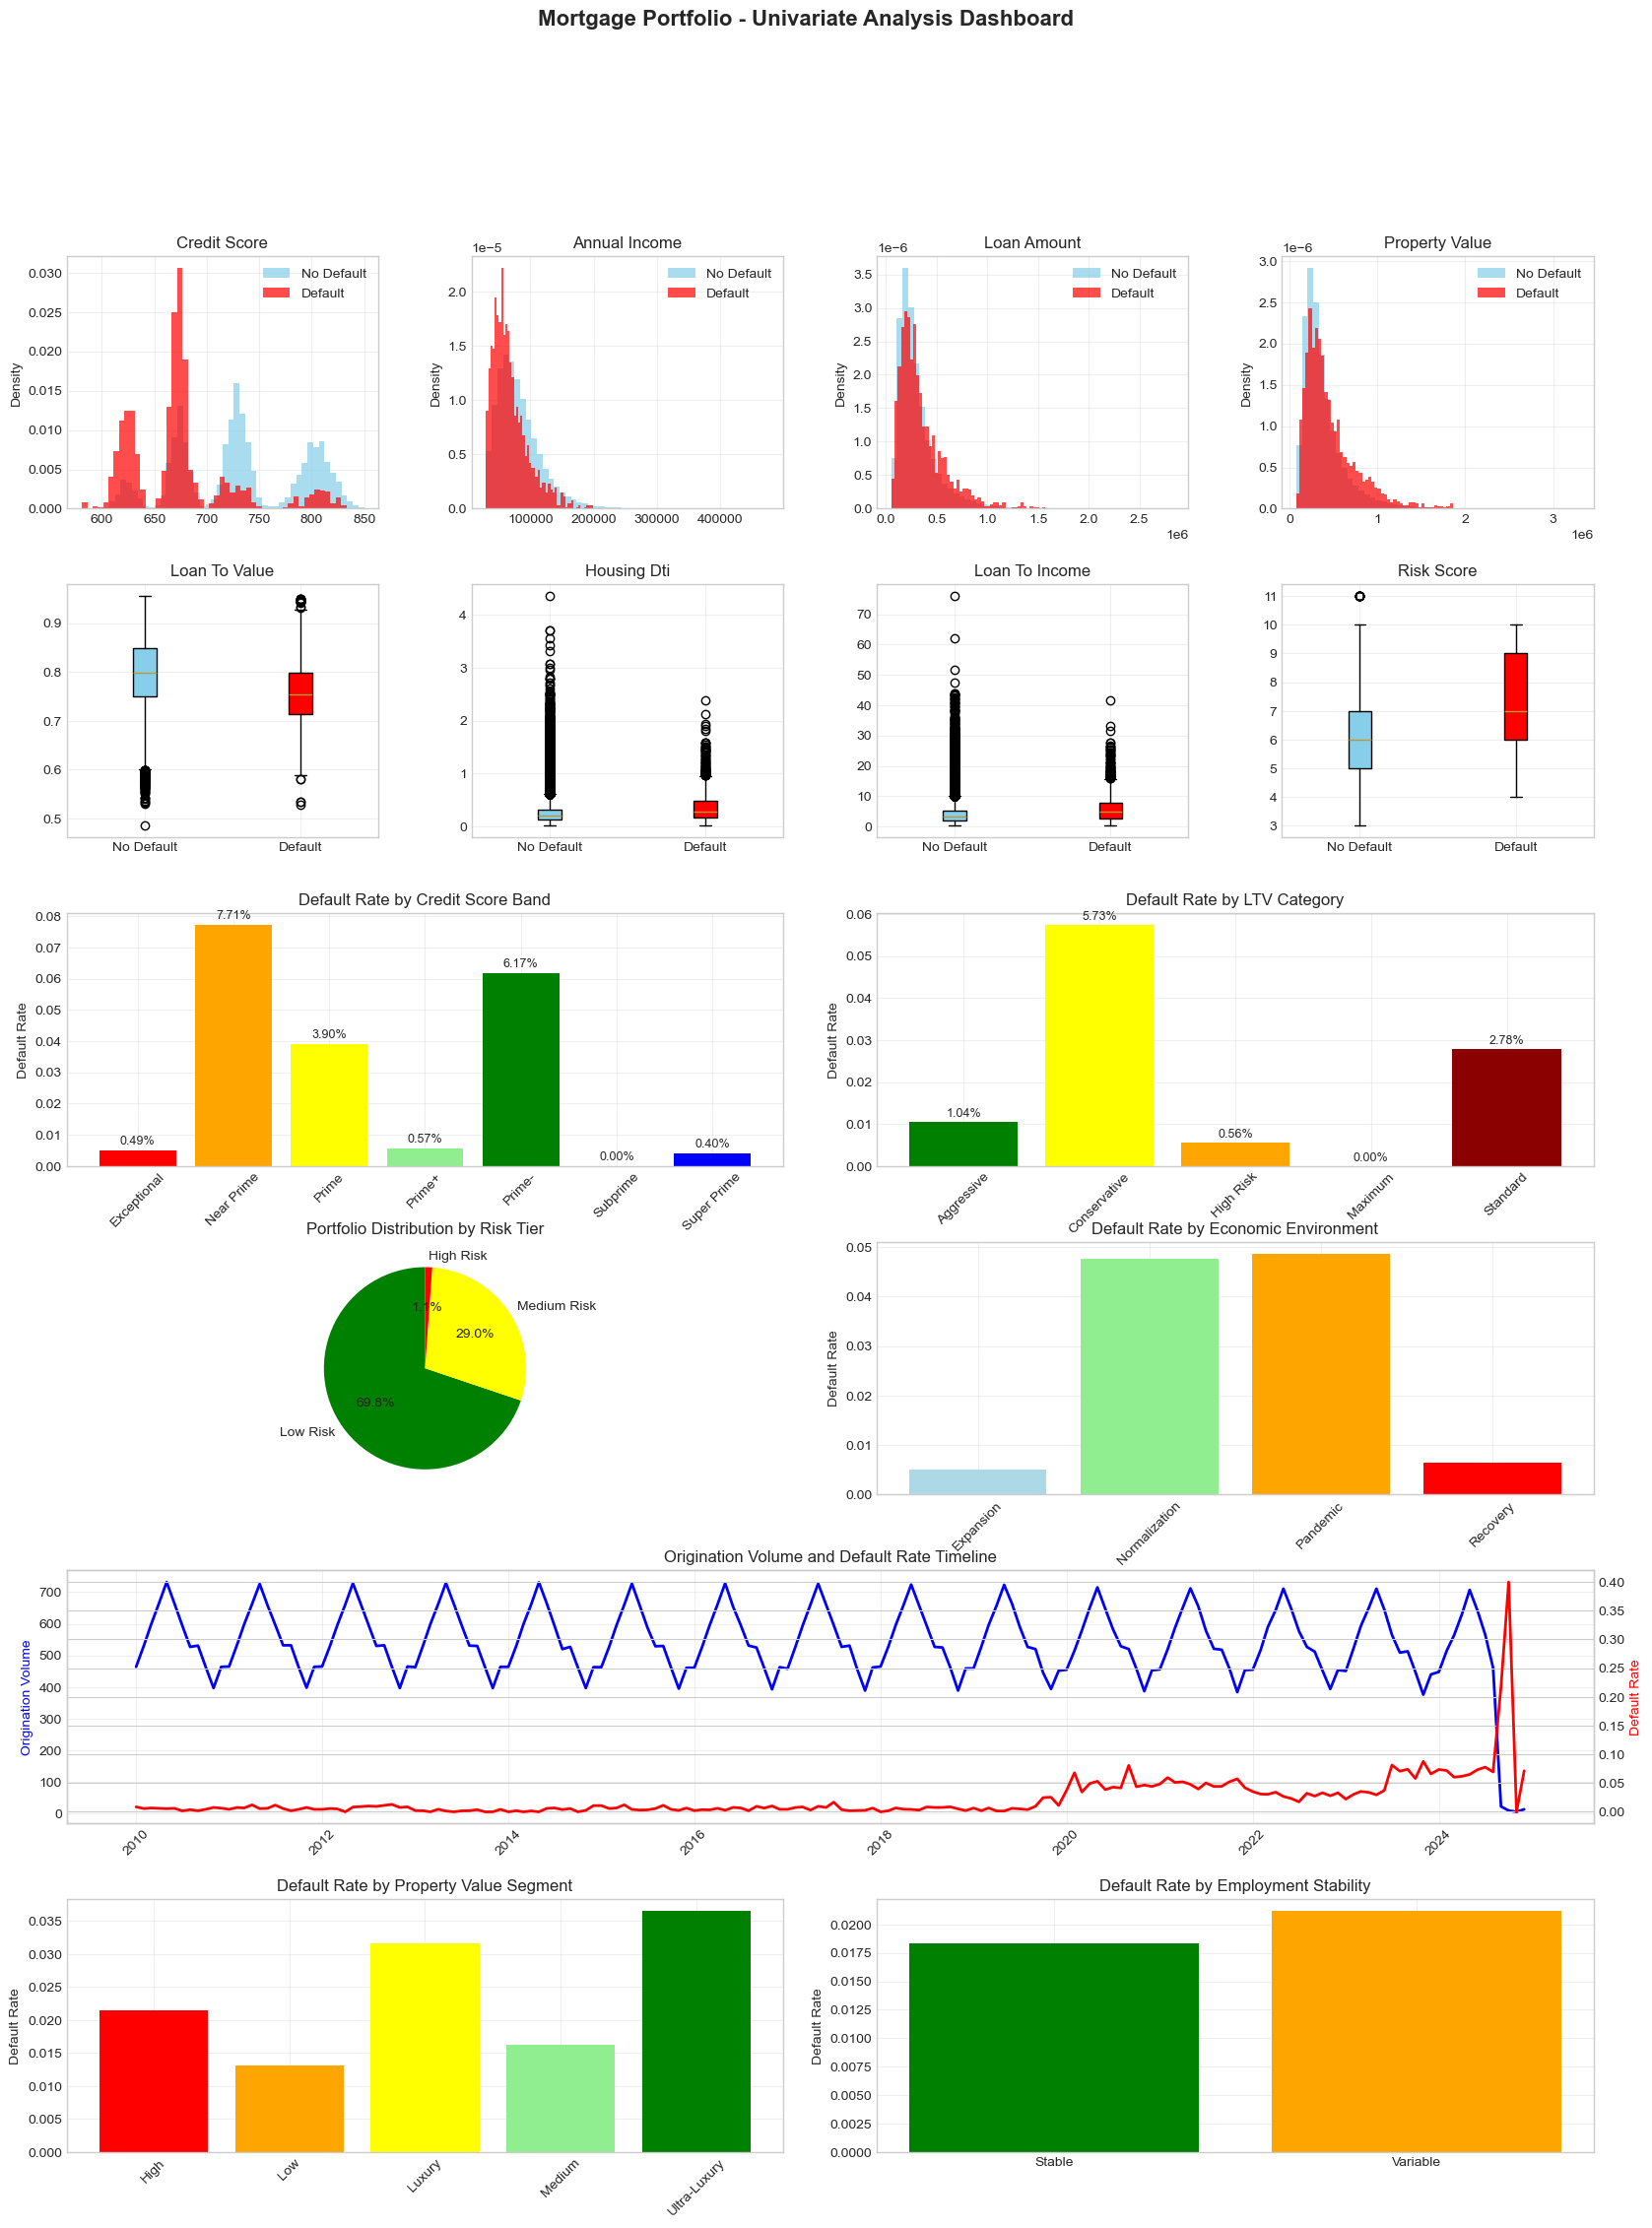

Univariate analysis dashboard completed


In [5]:


# Create comprehensive visualization dashboard for univariate analysis
def create_univariate_dashboard(df, numerical_features, categorical_features):
    """Create comprehensive univariate analysis dashboard"""
    
    # Set up the plotting grid
    fig = plt.figure(figsize=(20, 25))
    gs = GridSpec(6, 4, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Mortgage Portfolio - Univariate Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Row 1: Key numerical distributions
    for i, feature in enumerate(numerical_features[:4]):
        ax = fig.add_subplot(gs[0, i])
        
        # Histogram with default overlay
        no_default = df[df['default_flag'] == 0][feature]
        default = df[df['default_flag'] == 1][feature]
        
        ax.hist(no_default, bins=50, alpha=0.7, label='No Default', density=True, color='skyblue')
        ax.hist(default, bins=50, alpha=0.7, label='Default', density=True, color='red')
        
        ax.set_title(f'{feature.replace("_", " ").title()}')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Row 2: More numerical distributions
    for i, feature in enumerate(numerical_features[4:8]):
        ax = fig.add_subplot(gs[1, i])
        
        # Box plot by default status
        box_data = [df[df['default_flag'] == 0][feature], df[df['default_flag'] == 1][feature]]
        box = ax.boxplot(box_data, labels=['No Default', 'Default'], patch_artist=True)
        box['boxes'][0].set_facecolor('skyblue')
        box['boxes'][1].set_facecolor('red')
        
        ax.set_title(f'{feature.replace("_", " ").title()}')
        ax.grid(True, alpha=0.3)
    
    # Row 3: Credit score and LTV analysis
    ax = fig.add_subplot(gs[2, :2])
    credit_default_rates = df.groupby('credit_score_band')['default_flag'].mean()
    bars = ax.bar(range(len(credit_default_rates)), credit_default_rates.values, 
                  color=['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen', 'blue'])
    ax.set_title('Default Rate by Credit Score Band')
    ax.set_ylabel('Default Rate')
    ax.set_xticks(range(len(credit_default_rates)))
    ax.set_xticklabels(credit_default_rates.index, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.2%}', ha='center', va='bottom', fontsize=9)
    
    ax = fig.add_subplot(gs[2, 2:])
    ltv_default_rates = df.groupby('ltv_category')['default_flag'].mean()
    bars = ax.bar(range(len(ltv_default_rates)), ltv_default_rates.values, 
                  color=['green', 'yellow', 'orange', 'red', 'darkred'])
    ax.set_title('Default Rate by LTV Category')
    ax.set_ylabel('Default Rate')
    ax.set_xticks(range(len(ltv_default_rates)))
    ax.set_xticklabels(ltv_default_rates.index, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f'{height:.2%}', ha='center', va='bottom', fontsize=9)
    
    # Row 4: Risk tier and economic environment
    ax = fig.add_subplot(gs[3, :2])
    risk_tier_counts = df['risk_tier'].value_counts()
    colors = ['green', 'yellow', 'red']
    wedges, texts, autotexts = ax.pie(risk_tier_counts.values, labels=risk_tier_counts.index, 
                                     autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title('Portfolio Distribution by Risk Tier')
    
    ax = fig.add_subplot(gs[3, 2:])
    econ_default_rates = df.groupby('economic_environment')['default_flag'].mean()
    bars = ax.bar(range(len(econ_default_rates)), econ_default_rates.values, 
                  color=['lightblue', 'lightgreen', 'orange', 'red'])
    ax.set_title('Default Rate by Economic Environment')
    ax.set_ylabel('Default Rate')
    ax.set_xticks(range(len(econ_default_rates)))
    ax.set_xticklabels(econ_default_rates.index, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Row 5: Origination trends
    ax = fig.add_subplot(gs[4, :])
    monthly_stats = df.groupby(df['origination_date'].dt.to_period('M')).agg({
        'default_flag': ['count', 'mean'],
        'loan_amount': 'mean'
    })
    monthly_stats.columns = ['Volume', 'Default_Rate', 'Avg_Loan_Amount']
    monthly_stats.index = monthly_stats.index.to_timestamp()
    
    ax2 = ax.twinx()
    ax.plot(monthly_stats.index, monthly_stats['Volume'], color='blue', linewidth=2, label='Origination Volume')
    ax2.plot(monthly_stats.index, monthly_stats['Default_Rate'], color='red', linewidth=2, label='Default Rate')
    
    ax.set_title('Origination Volume and Default Rate Timeline')
    ax.set_ylabel('Origination Volume', color='blue')
    ax2.set_ylabel('Default Rate', color='red')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Row 6: Property and employment analysis
    ax = fig.add_subplot(gs[5, :2])
    prop_seg_defaults = df.groupby('property_value_segment')['default_flag'].mean()
    bars = ax.bar(range(len(prop_seg_defaults)), prop_seg_defaults.values, 
                  color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
    ax.set_title('Default Rate by Property Value Segment')
    ax.set_ylabel('Default Rate')
    ax.set_xticks(range(len(prop_seg_defaults)))
    ax.set_xticklabels(prop_seg_defaults.index, rotation=45)
    ax.grid(True, alpha=0.3)
    
    ax = fig.add_subplot(gs[5, 2:])
    emp_stability_defaults = df.groupby('employment_stability')['default_flag'].mean()
    bars = ax.bar(range(len(emp_stability_defaults)), emp_stability_defaults.values, 
                  color=['green', 'orange'])
    ax.set_title('Default Rate by Employment Stability')
    ax.set_ylabel('Default Rate')
    ax.set_xticks(range(len(emp_stability_defaults)))
    ax.set_xticklabels(emp_stability_defaults.index)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create comprehensive univariate dashboard
create_univariate_dashboard(loan_data, key_numerical_features, key_categorical_features)

print("Univariate analysis dashboard completed")


BIVARIATE ANALYSIS - CORRELATION ASSESSMENT

Correlations with DEFAULT_FLAG:
----------------------------------------
credit_score        : -0.1323 ***
risk_score          :  0.1108 ***
loan_to_value       : -0.0769 **
loan_to_income      :  0.0662 **
housing_dti         :  0.0620 **
annual_income       : -0.0542 **
property_value      :  0.0463 *
loan_amount         :  0.0334 *

Multicollinearity Assessment:
----------------------------------------
High correlation pairs (>0.7):
  credit_score <-> loan_to_value: 0.715
  loan_amount <-> property_value: 0.987
  loan_amount <-> housing_dti: 0.779
  loan_amount <-> loan_to_income: 0.805
  property_value <-> housing_dti: 0.786
  property_value <-> loan_to_income: 0.812
  housing_dti <-> loan_to_income: 0.968
  housing_dti <-> risk_score: 0.717
  loan_to_income <-> risk_score: 0.711


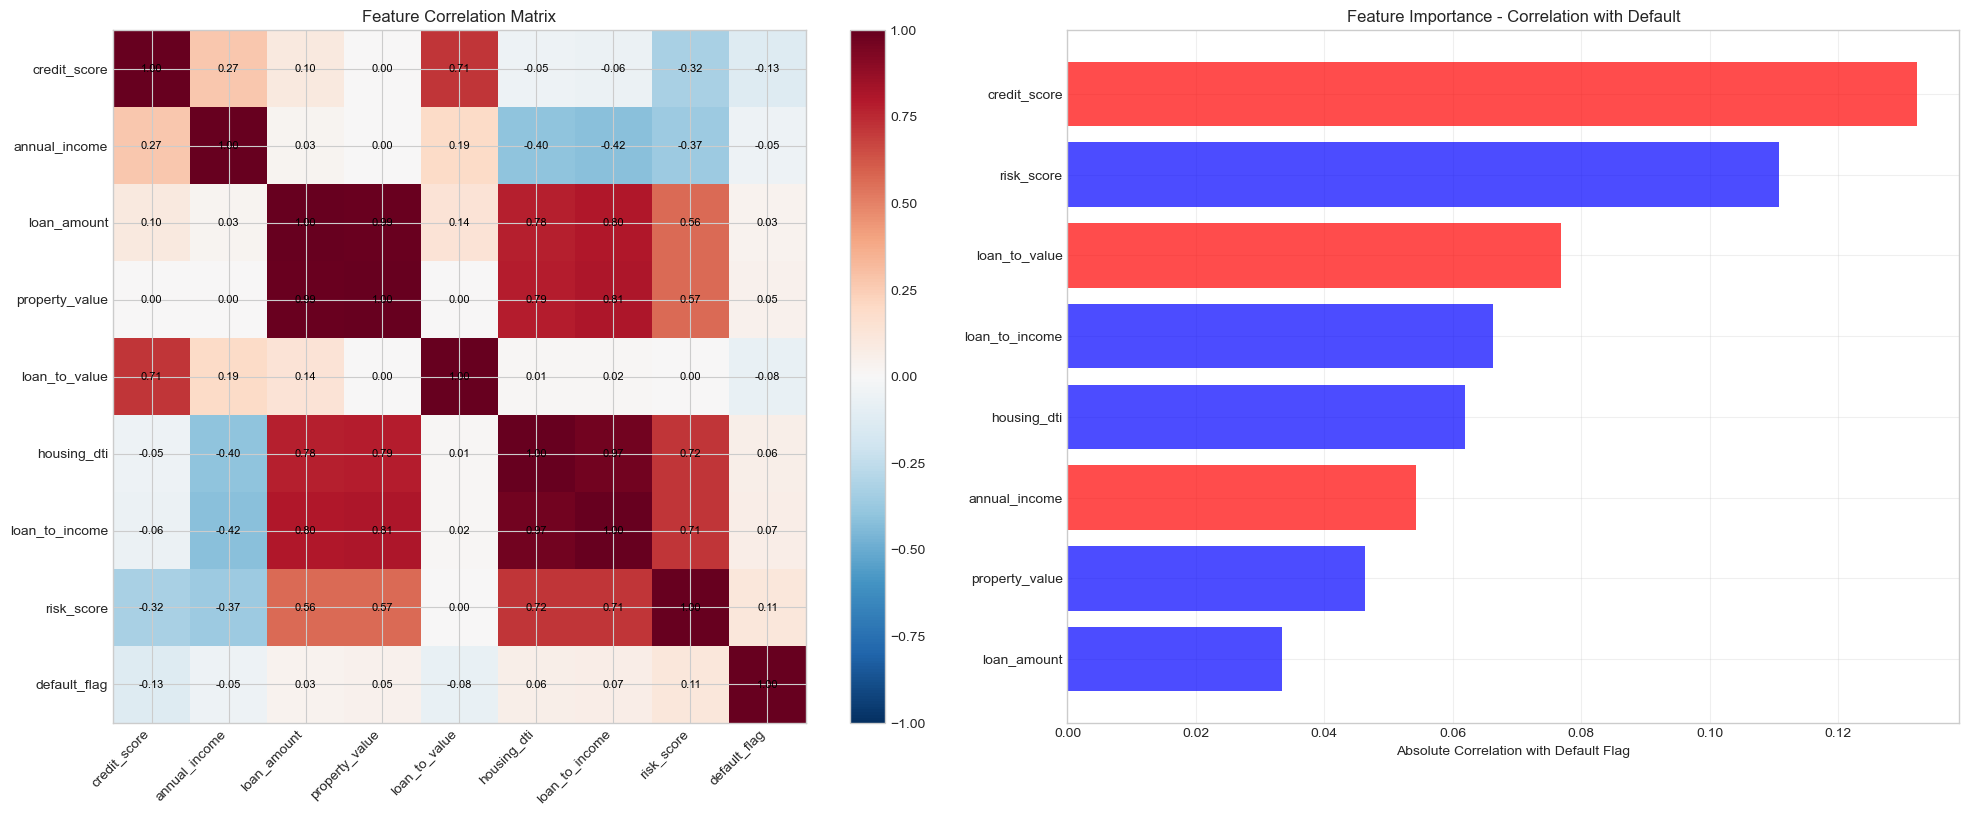


Correlation analysis completed


In [6]:


# Advanced bivariate analysis and correlation assessment
def perform_correlation_analysis(df, numerical_features, target='default_flag'):
    """Comprehensive correlation analysis for numerical features"""
    
    print("BIVARIATE ANALYSIS - CORRELATION ASSESSMENT")
    print("=" * 60)
    
    # Calculate correlation matrix
    corr_features = numerical_features + [target]
    correlation_matrix = df[corr_features].corr()
    
    # Extract correlations with target variable
    target_correlations = correlation_matrix[target].drop(target).sort_values(key=abs, ascending=False)
    
    print(f"\nCorrelations with {target.upper()}:")
    print("-" * 40)
    for feature, corr in target_correlations.items():
        significance = "***" if abs(corr) > 0.1 else "**" if abs(corr) > 0.05 else "*" if abs(corr) > 0.02 else ""
        print(f"{feature:<20}: {corr:>7.4f} {significance}")
    
    # Identify multicollinearity issues
    print(f"\nMulticollinearity Assessment:")
    print("-" * 40)
    high_corr_pairs = []
    for i in range(len(numerical_features)):
        for j in range(i+1, len(numerical_features)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                high_corr_pairs.append((numerical_features[i], numerical_features[j], corr_value))
    
    if high_corr_pairs:
        print("High correlation pairs (>0.7):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print("No high correlation pairs detected")
    
    return correlation_matrix, target_correlations

# Perform correlation analysis
correlation_matrix, target_correlations = perform_correlation_analysis(loan_data, key_numerical_features)

# Create correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation matrix
im1 = axes[0].imshow(correlation_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(correlation_matrix.columns)))
axes[0].set_yticks(range(len(correlation_matrix.columns)))
axes[0].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
axes[0].set_yticklabels(correlation_matrix.columns)
axes[0].set_title('Feature Correlation Matrix')

# Add correlation values to heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = axes[0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im1, ax=axes[0])

# Target correlations bar chart
target_corr_abs = target_correlations.abs().sort_values(ascending=True)
colors = ['red' if x < 0 else 'blue' for x in target_correlations[target_corr_abs.index]]
bars = axes[1].barh(range(len(target_corr_abs)), target_corr_abs.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(target_corr_abs)))
axes[1].set_yticklabels(target_corr_abs.index)
axes[1].set_xlabel('Absolute Correlation with Default Flag')
axes[1].set_title('Feature Importance - Correlation with Default')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation analysis completed")


In [7]:

# Address multicollinearity issues following industry best practices
def resolve_multicollinearity_issues(df, correlation_matrix, threshold=0.7):
    """
    Resolve multicollinearity issues using industry-standard approaches
    Following Federal Reserve model risk management guidelines
    """
    
    print("MULTICOLLINEARITY RESOLUTION - INDUSTRY APPROACH")
    print("=" * 60)
    
    # 1. Calculate Variance Inflation Factor (VIF) for quantitative assessment
    print("\n1. VARIANCE INFLATION FACTOR ANALYSIS")
    print("-" * 40)
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    numerical_features_for_vif = [
        'credit_score', 'annual_income', 'loan_amount', 'property_value',
        'loan_to_value', 'housing_dti', 'loan_to_income', 'risk_score'
    ]
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numerical_features_for_vif
    
    X_vif = df[numerical_features_for_vif].fillna(df[numerical_features_for_vif].mean())
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                       for i in range(len(numerical_features_for_vif))]
    
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("VIF Analysis (>5 indicates multicollinearity, >10 severe):")
    for _, row in vif_data.iterrows():
        status = "SEVERE" if row['VIF'] > 10 else "HIGH" if row['VIF'] > 5 else "✓ OK"
        print(f"  {row['Feature']:<20}: {row['VIF']:>8.2f} {status}")
    
    # 2. Industry decision framework for feature selection
    print("\n2. INDUSTRY DECISION FRAMEWORK")
    print("-" * 40)
    
    # Define feature priority based on industry standards
    feature_priority = {
        # Tier 1: Regulatory required + primary risk drivers
        'credit_score': {'priority': 1, 'reason': 'Primary risk driver - regulatory standard'},
        'housing_dti': {'priority': 1, 'reason': 'Regulatory requirement (QM rule)'},
        'loan_to_value': {'priority': 1, 'reason': 'Key collateral risk measure'},
        
        # Tier 2: Important for business but may have alternatives
        'annual_income': {'priority': 2, 'reason': 'Capacity assessment - business critical'},
        'loan_amount': {'priority': 2, 'reason': 'Exposure management - preferred over property value'},
        
        # Tier 3: Derived features - useful but can be recreated
        'risk_score': {'priority': 3, 'reason': 'Engineered feature - can be recreated'},
        
        # Tier 4: Redundant features - candidates for removal
        'property_value': {'priority': 4, 'reason': 'Redundant with loan_amount (r=0.987)'},
        'loan_to_income': {'priority': 4, 'reason': 'Redundant with housing_dti (r=0.968)'}
    }
    
    print("Feature Selection Decision Framework:")
    for feature, info in feature_priority.items():
        tier = f"Tier {info['priority']}"
        print(f"  {feature:<20}: {tier} - {info['reason']}")
    
    # 3. Recommended feature set following industry standards
    print("\n3. RECOMMENDED FEATURE SET")
    print("-" * 40)
    
    # Keep features following industry hierarchy
    recommended_features = {
        'keep': [
            'credit_score',      # Primary risk driver
            'housing_dti',       # Regulatory standard
            'loan_to_value',     # Collateral risk
            'annual_income',     # Capacity measure
            'loan_amount',       # Exposure management
            'risk_score'         # Engineered summary (if VIF acceptable)
        ],
        'remove': [
            'property_value',    # Redundant with loan_amount
            'loan_to_income'     # Redundant with housing_dti
        ]
    }
    
    # Check if risk_score should be kept based on VIF
    risk_score_vif = vif_data[vif_data['Feature'] == 'risk_score']['VIF'].iloc[0]
    if risk_score_vif > 10:
        recommended_features['remove'].append('risk_score')
        recommended_features['keep'].remove('risk_score')
        print(" Risk score removed due to high VIF")
    
    print("RECOMMENDED ACTIONS:")
    print(f"✓ Keep ({len(recommended_features['keep'])} features):")
    for feature in recommended_features['keep']:
        vif_val = vif_data[vif_data['Feature'] == feature]['VIF'].iloc[0]
        print(f"    {feature} (VIF: {vif_val:.1f})")
    
    print(f"✗ Remove ({len(recommended_features['remove'])} features):")
    for feature in recommended_features['remove']:
        vif_val = vif_data[vif_data['Feature'] == feature]['VIF'].iloc[0]
        print(f"    {feature} (VIF: {vif_val:.1f})")
    
    # 4. Validate decision with correlation check
    print("\n4. VALIDATION - REMAINING CORRELATIONS")
    print("-" * 40)
    
    remaining_features = recommended_features['keep']
    remaining_corr = correlation_matrix.loc[remaining_features, remaining_features]
    
    # Check for remaining high correlations
    high_corr_remaining = []
    for i in range(len(remaining_features)):
        for j in range(i+1, len(remaining_features)):
            corr_value = remaining_corr.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_remaining.append((remaining_features[i], remaining_features[j], corr_value))
    
    if high_corr_remaining:
        print("Remaining high correlations:")
        for feat1, feat2, corr in high_corr_remaining:
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")
        print("\n Consider additional feature selection if issues persist")
    else:
        print("✓ No remaining high correlations detected")
        print("✓ Feature set ready for modeling")
    
    # 5. Industry rationale summary
    print("\n5. INDUSTRY RATIONALE SUMMARY")
    print("-" * 40)
    print("This selection follows standard practices at major banks:")
    print("• Credit score: Universally required primary risk factor")
    print("• DTI: Federal requirement under Qualified Mortgage rule")
    print("• LTV: Standard collateral risk assessment")
    print("• Income/Loan amount: Essential for capacity and exposure")
    print("• Removed redundant features to prevent model instability")
    print("• Maintained interpretability for regulatory review")
    
    return recommended_features, vif_data

# Apply multicollinearity resolution
recommended_features, vif_analysis = resolve_multicollinearity_issues(loan_data, correlation_matrix)

print(f"\nMulticollinearity resolution completed following industry standards")
print(f"Recommended modeling features: {len(recommended_features['keep'])}")

MULTICOLLINEARITY RESOLUTION - INDUSTRY APPROACH

1. VARIANCE INFLATION FACTOR ANALYSIS
----------------------------------------
VIF Analysis (>5 indicates multicollinearity, >10 severe):
  loan_to_value       :   535.83 SEVERE
  credit_score        :   381.58 SEVERE
  property_value      :   233.55 SEVERE
  loan_amount         :   216.56 SEVERE
  risk_score          :    56.47 SEVERE
  loan_to_income      :    55.77 SEVERE
  housing_dti         :    40.95 SEVERE
  annual_income       :    14.94 SEVERE

2. INDUSTRY DECISION FRAMEWORK
----------------------------------------
Feature Selection Decision Framework:
  credit_score        : Tier 1 - Primary risk driver - regulatory standard
  housing_dti         : Tier 1 - Regulatory requirement (QM rule)
  loan_to_value       : Tier 1 - Key collateral risk measure
  annual_income       : Tier 2 - Capacity assessment - business critical
  loan_amount         : Tier 2 - Exposure management - preferred over property value
  risk_score         

In [8]:

# Portfolio segmentation and risk concentration analysis
def analyze_portfolio_concentration(df):
    """Analyze portfolio concentrations and risk segments"""
    
    print("PORTFOLIO CONCENTRATION AND RISK ANALYSIS")
    print("=" * 60)
    
    # Geographic concentration analysis
    print("\n1. GEOGRAPHIC CONCENTRATION")
    print("-" * 30)
    state_analysis = df.groupby('state').agg({
        'default_flag': ['count', 'sum', 'mean'],
        'loan_amount': 'sum'
    }).round(4)
    
    state_analysis.columns = ['Loan_Count', 'Defaults', 'Default_Rate', 'Total_Exposure']
    state_analysis['Portfolio_Share'] = state_analysis['Loan_Count'] / len(df)
    state_analysis['Exposure_Share'] = state_analysis['Total_Exposure'] / state_analysis['Total_Exposure'].sum()
    
    # Top 10 states by portfolio share
    top_states = state_analysis.nlargest(10, 'Portfolio_Share')
    print("Top 10 states by portfolio concentration:")
    for state in top_states.index:
        loan_pct = top_states.loc[state, 'Portfolio_Share']
        exposure_pct = top_states.loc[state, 'Exposure_Share'] 
        default_rate = top_states.loc[state, 'Default_Rate']
        print(f"  {state}: {loan_pct:.1%} loans, {exposure_pct:.1%} exposure, {default_rate:.2%} default rate")
    
    # Economic environment analysis
    print("\n2. ECONOMIC ENVIRONMENT ANALYSIS")
    print("-" * 30)
    econ_analysis = df.groupby('economic_environment').agg({
        'default_flag': ['count', 'sum', 'mean'],
        'credit_score': 'mean',
        'loan_to_value': 'mean'
    }).round(4)
    
    econ_analysis.columns = ['Loan_Count', 'Defaults', 'Default_Rate', 'Avg_FICO', 'Avg_LTV']
    
    for env in econ_analysis.index:
        count = econ_analysis.loc[env, 'Loan_Count']
        rate = econ_analysis.loc[env, 'Default_Rate']
        fico = econ_analysis.loc[env, 'Avg_FICO']
        ltv = econ_analysis.loc[env, 'Avg_LTV']
        print(f"  {env}: {count:,} loans, {rate:.2%} default, {fico:.0f} avg FICO, {ltv:.1%} avg LTV")
    
    # Risk tier concentration
    print("\n3. RISK TIER CONCENTRATION")
    print("-" * 30)
    risk_analysis = df.groupby('risk_tier').agg({
        'default_flag': ['count', 'sum', 'mean'],
        'loan_amount': 'sum'
    }).round(4)
    
    risk_analysis.columns = ['Loan_Count', 'Defaults', 'Default_Rate', 'Total_Exposure']
    risk_analysis['Portfolio_Share'] = risk_analysis['Loan_Count'] / len(df)
    
    for tier in risk_analysis.index:
        count = risk_analysis.loc[tier, 'Loan_Count']
        share = risk_analysis.loc[tier, 'Portfolio_Share']
        rate = risk_analysis.loc[tier, 'Default_Rate']
        print(f"  {tier}: {count:,} loans ({share:.1%}), {rate:.2%} default rate")
    
    # Vintage analysis
    print("\n4. VINTAGE ANALYSIS")
    print("-" * 30)
    vintage_analysis = df.groupby('origination_year').agg({
        'default_flag': ['count', 'sum', 'mean'],
        'credit_score': 'mean',
        'loan_to_value': 'mean'
    }).round(4)
    
    vintage_analysis.columns = ['Loan_Count', 'Defaults', 'Default_Rate', 'Avg_FICO', 'Avg_LTV']
    
    for year in sorted(vintage_analysis.index):
        count = vintage_analysis.loc[year, 'Loan_Count']
        rate = vintage_analysis.loc[year, 'Default_Rate']
        fico = vintage_analysis.loc[year, 'Avg_FICO']
        print(f"  {year}: {count:,} loans, {rate:.2%} default, {fico:.0f} avg FICO")
    
    return state_analysis, econ_analysis, risk_analysis, vintage_analysis

# Perform portfolio concentration analysis
state_analysis, econ_analysis, risk_analysis, vintage_analysis = analyze_portfolio_concentration(loan_data)

print("\nPortfolio concentration analysis completed")



PORTFOLIO CONCENTRATION AND RISK ANALYSIS

1. GEOGRAPHIC CONCENTRATION
------------------------------
Top 10 states by portfolio concentration:
  OTHER: 34.8% loans, 27.1% exposure, 1.68% default rate
  CA: 10.6% loans, 22.5% exposure, 3.11% default rate
  TX: 8.1% loans, 6.9% exposure, 1.54% default rate
  FL: 7.1% loans, 7.1% exposure, 1.89% default rate
  NY: 5.3% loans, 6.8% exposure, 2.28% default rate
  PA: 4.5% loans, 2.5% exposure, 1.58% default rate
  IL: 3.6% loans, 2.6% exposure, 1.77% default rate
  GA: 3.6% loans, 2.5% exposure, 1.26% default rate
  NC: 3.6% loans, 2.8% exposure, 1.87% default rate
  OH: 3.5% loans, 1.8% exposure, 1.20% default rate

2. ECONOMIC ENVIRONMENT ANALYSIS
------------------------------
  Expansion: 46,169 loans, 0.51% default, 743 avg FICO, 80.9% avg LTV
  Normalization: 17,493 loans, 4.76% default, 652 avg FICO, 73.1% avg LTV
  Pandemic: 12,986 loans, 4.86% default, 674 avg FICO, 74.9% avg LTV
  Recovery: 19,887 loans, 0.65% default, 805 avg FI

In [9]:

# Advanced statistical testing and feature relationships
def perform_statistical_tests(df):
    """Perform comprehensive statistical tests for feature relationships"""
    
    print("ADVANCED STATISTICAL TESTING")
    print("=" * 60)
    
    # 1. Test for differences in means across risk tiers
    print("\n1. ANOVA TESTS - RISK TIER DIFFERENCES")
    print("-" * 40)
    
    risk_groups = [df[df['risk_tier'] == tier] for tier in df['risk_tier'].unique()]
    
    # Test key numerical features across risk tiers
    test_features = ['credit_score', 'housing_dti', 'loan_to_value', 'loan_to_income']
    
    for feature in test_features:
        feature_groups = [group[feature].dropna() for group in risk_groups]
        f_stat, p_value = stats.f_oneway(*feature_groups)
        
        print(f"{feature}:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value: {p_value:.6f}")
        print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
    
    # 2. Test for independence between categorical variables
    print("\n2. CHI-SQUARE TESTS - CATEGORICAL INDEPENDENCE")
    print("-" * 40)
    
    categorical_pairs = [
        ('credit_score_band', 'economic_environment'),
        ('ltv_category', 'risk_tier'),
        ('employment_stability', 'default_flag'),
        ('loan_purpose', 'default_flag')
    ]
    
    for var1, var2 in categorical_pairs:
        contingency_table = pd.crosstab(df[var1], df[var2])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        print(f"{var1} vs {var2}:")
        print(f"  Chi-square: {chi2:.4f}")
        print(f"  P-value: {p_value:.6f}")
        print(f"  Independent: {'No' if p_value < 0.05 else 'Yes'}")
    
    # 3. Economic environment impact analysis
    print("\n3. ECONOMIC ENVIRONMENT IMPACT ANALYSIS")
    print("-" * 40)
    
    econ_groups = df.groupby('economic_environment')['default_flag'].agg(['count', 'sum', 'mean'])
    
    # Test for significant differences in default rates between economic periods
    environments = df['economic_environment'].unique()
    for i, env1 in enumerate(environments):
        for env2 in environments[i+1:]:
            group1 = df[df['economic_environment'] == env1]['default_flag']
            group2 = df[df['economic_environment'] == env2]['default_flag']
            
            # Two-proportion z-test
            count1, count2 = len(group1), len(group2)
            success1, success2 = group1.sum(), group2.sum()
            
            if count1 > 0 and count2 > 0:
                z_stat, p_value = proportions_ztest([success1, success2], [count1, count2])
                
                rate1 = success1 / count1
                rate2 = success2 / count2
                
                print(f"{env1} vs {env2}:")
                print(f"  Rates: {rate1:.3%} vs {rate2:.3%}")
                print(f"  Z-statistic: {z_stat:.4f}")
                print(f"  P-value: {p_value:.6f}")
    
    return True

# Perform statistical tests
statistical_results = perform_statistical_tests(loan_data)

print("\nStatistical testing completed")


ADVANCED STATISTICAL TESTING

1. ANOVA TESTS - RISK TIER DIFFERENCES
----------------------------------------
credit_score:
  F-statistic: 3021.1973
  P-value: 0.000000
  Significant: Yes
housing_dti:
  F-statistic: 39955.0245
  P-value: 0.000000
  Significant: Yes
loan_to_value:
  F-statistic: 14.3594
  P-value: 0.000001
  Significant: Yes
loan_to_income:
  F-statistic: 38793.1989
  P-value: 0.000000
  Significant: Yes

2. CHI-SQUARE TESTS - CATEGORICAL INDEPENDENCE
----------------------------------------
credit_score_band vs economic_environment:
  Chi-square: 154935.2884
  P-value: 0.000000
  Independent: No
ltv_category vs risk_tier:
  Chi-square: 361.9331
  P-value: 0.000000
  Independent: No
employment_stability vs default_flag:
  Chi-square: 6.3186
  P-value: 0.011948
  Independent: No
loan_purpose vs default_flag:
  Chi-square: 1.5141
  P-value: 0.469044
  Independent: Yes

3. ECONOMIC ENVIRONMENT IMPACT ANALYSIS
----------------------------------------
Recovery vs Expansion:


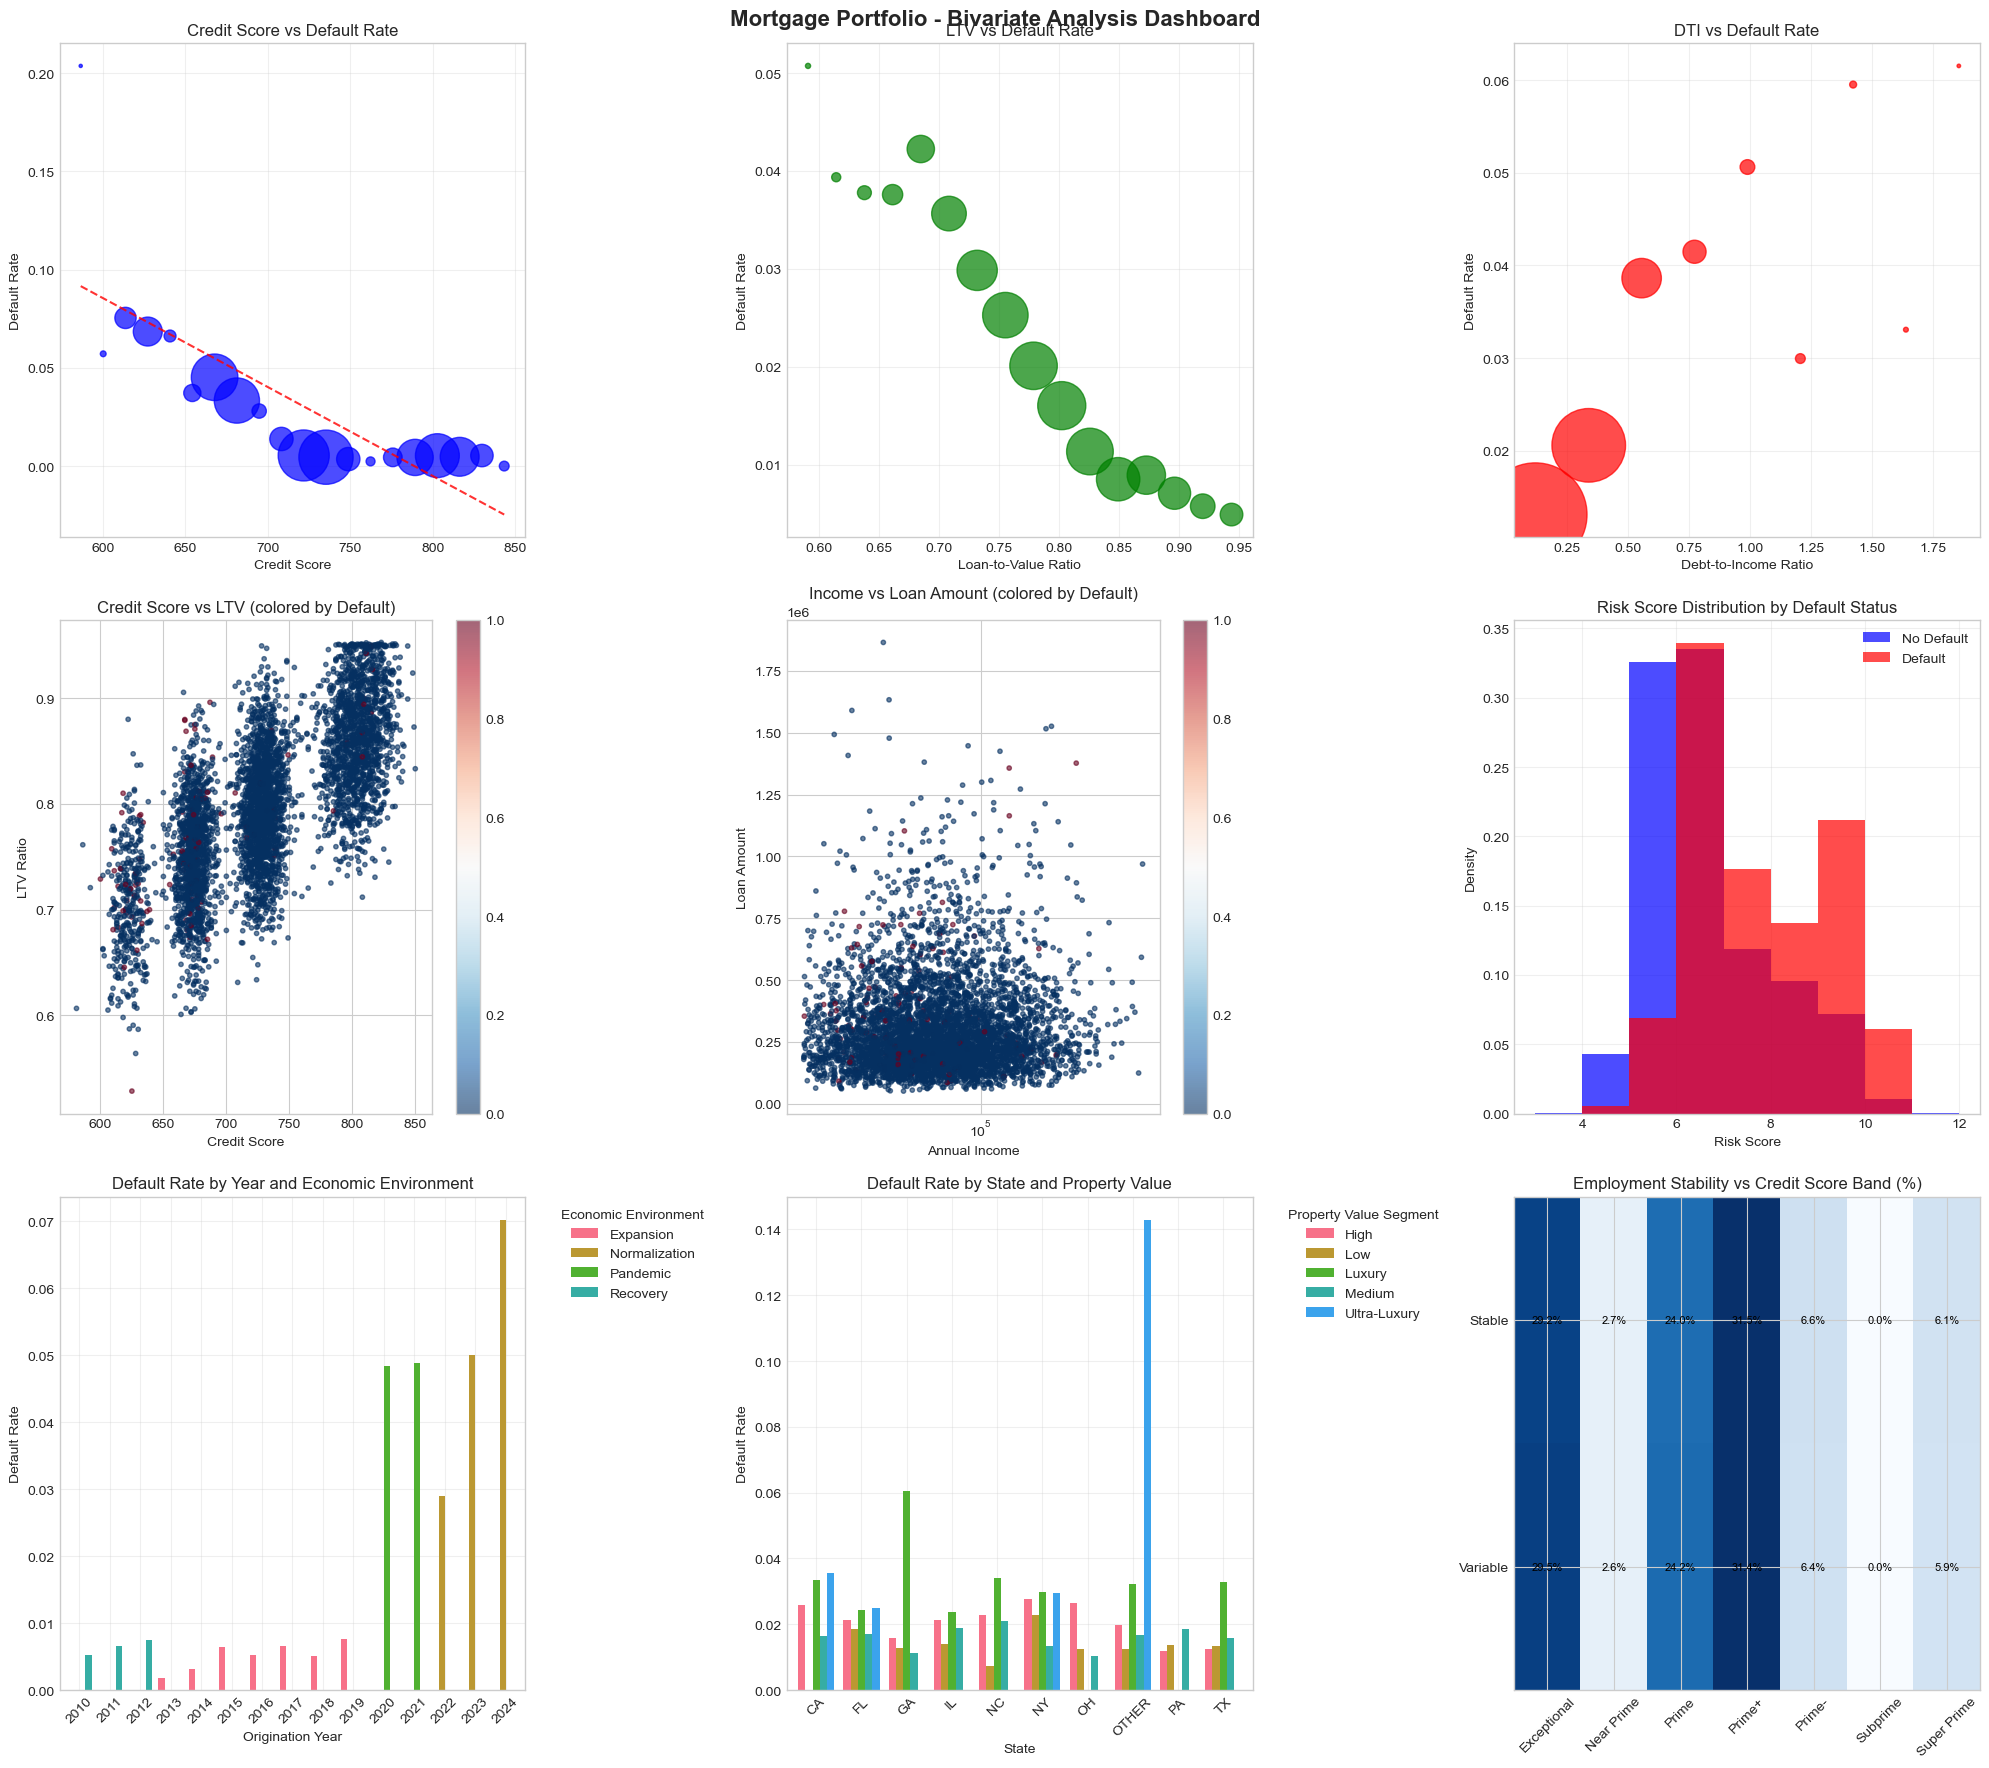

Bivariate analysis dashboard completed


In [10]:

# Create comprehensive bivariate analysis dashboard
def create_bivariate_dashboard(df):
    """Create comprehensive bivariate analysis visualizations"""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Mortgage Portfolio - Bivariate Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Credit Score vs Default Rate (Scatter with trend)
    credit_score_bins = pd.cut(df['credit_score'], bins=20)
    credit_binned_stats = df.groupby(credit_score_bins)['default_flag'].agg(['mean', 'count'])
    credit_binned_stats = credit_binned_stats[credit_binned_stats['count'] >= 50]  # Filter small bins
    
    bin_centers = [interval.mid for interval in credit_binned_stats.index]
    axes[0,0].scatter(bin_centers, credit_binned_stats['mean'], 
                     s=credit_binned_stats['count']/10, alpha=0.7, color='blue')
    
    # Add trend line
    z = np.polyfit(bin_centers, credit_binned_stats['mean'], 1)
    p = np.poly1d(z)
    axes[0,0].plot(bin_centers, p(bin_centers), "r--", alpha=0.8)
    
    axes[0,0].set_title('Credit Score vs Default Rate')
    axes[0,0].set_xlabel('Credit Score')
    axes[0,0].set_ylabel('Default Rate')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. LTV vs Default Rate
    ltv_bins = pd.cut(df['loan_to_value'], bins=20)
    ltv_binned_stats = df.groupby(ltv_bins)['default_flag'].agg(['mean', 'count'])
    ltv_binned_stats = ltv_binned_stats[ltv_binned_stats['count'] >= 50]
    
    bin_centers = [interval.mid for interval in ltv_binned_stats.index]
    axes[0,1].scatter(bin_centers, ltv_binned_stats['mean'], 
                     s=ltv_binned_stats['count']/10, alpha=0.7, color='green')
    
    axes[0,1].set_title('LTV vs Default Rate')
    axes[0,1].set_xlabel('Loan-to-Value Ratio')
    axes[0,1].set_ylabel('Default Rate')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. DTI vs Default Rate
    dti_bins = pd.cut(df['housing_dti'], bins=20)
    dti_binned_stats = df.groupby(dti_bins)['default_flag'].agg(['mean', 'count'])
    dti_binned_stats = dti_binned_stats[dti_binned_stats['count'] >= 50]
    
    bin_centers = [interval.mid for interval in dti_binned_stats.index]
    axes[0,2].scatter(bin_centers, dti_binned_stats['mean'], 
                     s=dti_binned_stats['count']/10, alpha=0.7, color='red')
    
    axes[0,2].set_title('DTI vs Default Rate')
    axes[0,2].set_xlabel('Debt-to-Income Ratio')
    axes[0,2].set_ylabel('Default Rate')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Credit Score vs LTV (colored by defaults)
    sample_data = df.sample(5000)  # Sample for performance
    scatter = axes[1,0].scatter(sample_data['credit_score'], sample_data['loan_to_value'], 
                               c=sample_data['default_flag'], cmap='RdBu_r', alpha=0.6, s=10)
    axes[1,0].set_title('Credit Score vs LTV (colored by Default)')
    axes[1,0].set_xlabel('Credit Score')
    axes[1,0].set_ylabel('LTV Ratio')
    plt.colorbar(scatter, ax=axes[1,0])
    
    # 5. Income vs Loan Amount (colored by defaults)
    scatter = axes[1,1].scatter(sample_data['annual_income'], sample_data['loan_amount'], 
                               c=sample_data['default_flag'], cmap='RdBu_r', alpha=0.6, s=10)
    axes[1,1].set_title('Income vs Loan Amount (colored by Default)')
    axes[1,1].set_xlabel('Annual Income')
    axes[1,1].set_ylabel('Loan Amount')
    axes[1,1].set_xscale('log')
    plt.colorbar(scatter, ax=axes[1,1])
    
    # 6. Risk Score Distribution by Default Status
    risk_scores_no_default = df[df['default_flag'] == 0]['risk_score']
    risk_scores_default = df[df['default_flag'] == 1]['risk_score']
    
    axes[1,2].hist(risk_scores_no_default, bins=range(3, 13), alpha=0.7, 
                   label='No Default', density=True, color='blue')
    axes[1,2].hist(risk_scores_default, bins=range(3, 13), alpha=0.7, 
                   label='Default', density=True, color='red')
    axes[1,2].set_title('Risk Score Distribution by Default Status')
    axes[1,2].set_xlabel('Risk Score')
    axes[1,2].set_ylabel('Density')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    # 7. Default Rate by Origination Year and Economic Environment
    yearly_econ_defaults = df.groupby(['origination_year', 'economic_environment'])['default_flag'].mean().unstack()
    yearly_econ_defaults.plot(kind='bar', ax=axes[2,0], width=0.8)
    axes[2,0].set_title('Default Rate by Year and Economic Environment')
    axes[2,0].set_xlabel('Origination Year')
    axes[2,0].set_ylabel('Default Rate')
    axes[2,0].legend(title='Economic Environment', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2,0].tick_params(axis='x', rotation=45)
    axes[2,0].grid(True, alpha=0.3)
    
    # 8. Property Value vs Default Rate by State (top states)
    top_states = df['state'].value_counts().head(10).index
    state_prop_defaults = df[df['state'].isin(top_states)].groupby(['state', 'property_value_segment'])['default_flag'].mean().unstack()
    state_prop_defaults.plot(kind='bar', ax=axes[2,1], width=0.8)
    axes[2,1].set_title('Default Rate by State and Property Value')
    axes[2,1].set_xlabel('State')
    axes[2,1].set_ylabel('Default Rate')
    axes[2,1].legend(title='Property Value Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2,1].tick_params(axis='x', rotation=45)
    axes[2,1].grid(True, alpha=0.3)
    
    # 9. Employment Stability vs Credit Score Band
    emp_credit_crosstab = pd.crosstab(df['employment_stability'], df['credit_score_band'], normalize='index') * 100
    im = axes[2,2].imshow(emp_credit_crosstab.values, cmap='Blues', aspect='auto')
    axes[2,2].set_xticks(range(len(emp_credit_crosstab.columns)))
    axes[2,2].set_yticks(range(len(emp_credit_crosstab.index)))
    axes[2,2].set_xticklabels(emp_credit_crosstab.columns, rotation=45)
    axes[2,2].set_yticklabels(emp_credit_crosstab.index)
    axes[2,2].set_title('Employment Stability vs Credit Score Band (%)')
    
    # Add percentage values to heatmap
    for i in range(len(emp_credit_crosstab.index)):
        for j in range(len(emp_credit_crosstab.columns)):
            text = axes[2,2].text(j, i, f'{emp_credit_crosstab.iloc[i, j]:.1f}%',
                                 ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Create bivariate analysis dashboard
create_bivariate_dashboard(loan_data)

print("Bivariate analysis dashboard completed")


In [11]:

# Generate comprehensive EDA summary and key insights
def generate_eda_insights(df, numerical_analysis, categorical_analysis, target_correlations):
    """Generate comprehensive insights from exploratory data analysis"""
    
    print("EXPLORATORY DATA ANALYSIS - KEY INSIGHTS")
    print("=" * 70)
    
    # 1. Portfolio overview insights
    print("\n1. PORTFOLIO OVERVIEW")
    print("-" * 30)
    total_loans = len(df)
    total_exposure = df['loan_amount'].sum()
    default_rate = df['default_flag'].mean()
    avg_loan_size = df['loan_amount'].mean()
    
    print(f"Total portfolio: {total_loans:,} loans")
    print(f"Total exposure: ${total_exposure:,.0f}")
    print(f"Overall default rate: {default_rate:.2%}")
    print(f"Average loan size: ${avg_loan_size:,.0f}")
    
    # 2. Risk driver insights
    print("\n2. PRIMARY RISK DRIVERS")
    print("-" * 30)
    
    # Top correlations with default
    top_risk_factors = target_correlations.abs().nlargest(5)
    print("Strongest predictors of default (by correlation):")
    for factor, corr in top_risk_factors.items():
        direction = "increases" if target_correlations[factor] > 0 else "decreases"
        print(f"  {factor}: {abs(corr):.3f} (default risk {direction} with higher values)")
    
    # 3. Credit quality insights
    print("\n3. CREDIT QUALITY ANALYSIS")
    print("-" * 30)
    
    credit_distribution = df['credit_score_band'].value_counts(normalize=True)
    print("Credit score distribution:")
    for band, pct in credit_distribution.items():
        print(f"  {band}: {pct:.1%}")
    
    avg_fico = df['credit_score'].mean()
    print(f"\nAverage FICO score: {avg_fico:.0f}")
    
    # Default rates by credit tier
    credit_defaults = df.groupby('credit_score_band')['default_flag'].mean()
    best_tier = credit_defaults.idxmin()
    worst_tier = credit_defaults.idxmax()
    print(f"Lowest default rate: {best_tier} ({credit_defaults[best_tier]:.2%})")
    print(f"Highest default rate: {worst_tier} ({credit_defaults[worst_tier]:.2%})")
    
    # 4. Collateral risk insights
    print("\n4. COLLATERAL AND LTV ANALYSIS")
    print("-" * 30)
    
    avg_ltv = df['loan_to_value'].mean()
    high_ltv_pct = (df['loan_to_value'] > 0.90).mean()
    
    print(f"Average LTV: {avg_ltv:.1%}")
    print(f"High LTV loans (>90%): {high_ltv_pct:.1%}")
    
    ltv_defaults = df.groupby('ltv_category')['default_flag'].mean()
    for category, rate in ltv_defaults.items():
        print(f"  {category} LTV default rate: {rate:.2%}")
    
    # 5. Economic environment insights
    print("\n5. ECONOMIC ENVIRONMENT IMPACT")
    print("-" * 30)
    
    econ_distribution = df['economic_environment'].value_counts(normalize=True)
    econ_defaults = df.groupby('economic_environment')['default_flag'].mean()
    
    print("Portfolio by economic environment:")
    for env in econ_distribution.index:
        pct = econ_distribution[env]
        default_rate = econ_defaults[env]
        print(f"  {env}: {pct:.1%} of portfolio, {default_rate:.2%} default rate")
    
    # 6. Geographic concentration insights
    print("\n6. GEOGRAPHIC CONCENTRATION")
    print("-" * 30)
    
    state_concentration = df['state'].value_counts(normalize=True).head(5)
    print("Top 5 states by loan count:")
    for state, pct in state_concentration.items():
        print(f"  {state}: {pct:.1%}")
    
    # Check for high geographic concentration
    top_5_concentration = state_concentration.sum()
    print(f"\nTop 5 states represent {top_5_concentration:.1%} of portfolio")
    if top_5_concentration > 0.6:
        print("High geographic concentration detected")
    
    # 7. Risk segmentation insights
    print("\n7. RISK TIER ANALYSIS")
    print("-" * 30)
    
    risk_distribution = df['risk_tier'].value_counts(normalize=True)
    risk_defaults = df.groupby('risk_tier')['default_flag'].mean()
    
    for tier in ['Low Risk', 'Medium Risk', 'High Risk']:
        if tier in risk_distribution.index:
            pct = risk_distribution[tier]
            default_rate = risk_defaults[tier]
            print(f"  {tier}: {pct:.1%} of portfolio, {default_rate:.2%} default rate")
    
    # 8. Key recommendations
    print("\n8. KEY RECOMMENDATIONS FOR MODEL DEVELOPMENT")
    print("-" * 45)
    
    recommendations = []
    
    # Risk factor recommendations
    top_factor = top_risk_factors.index[0]
    recommendations.append(f"Prioritize {top_factor} as primary risk driver in models")
    
    # Class imbalance recommendation
    if default_rate < 0.05:
        recommendations.append("Address class imbalance using sampling techniques or cost-sensitive learning")
    
    # Feature engineering recommendations
    high_corr_features = [f for f, c in target_correlations.items() if abs(c) > 0.05]
    recommendations.append(f"Focus feature engineering on {len(high_corr_features)} high-correlation features")
    
    # Economic segmentation recommendation
    econ_range = econ_defaults.max() - econ_defaults.min()
    if econ_range > 0.01:
        recommendations.append("Consider economic environment segmentation for model development")
    
    # Geographic consideration
    if top_5_concentration > 0.6:
        recommendations.append("Monitor geographic concentration risk in model validation")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")
    
    return {
        'portfolio_metrics': {
            'total_loans': total_loans,
            'default_rate': default_rate,
            'avg_fico': avg_fico,
            'avg_ltv': avg_ltv
        },
        'top_risk_factors': top_risk_factors,
        'recommendations': recommendations
    }

# Generate comprehensive insights
eda_insights = generate_eda_insights(loan_data, numerical_analysis, categorical_analysis, target_correlations)

print(f"\nExploratory Data Analysis completed successfully!")
print(f"Dataset ready for model development with comprehensive feature understanding")
print(f"\nNext step: Proceed to Notebook 05 - Model Development")


EXPLORATORY DATA ANALYSIS - KEY INSIGHTS

1. PORTFOLIO OVERVIEW
------------------------------
Total portfolio: 96,535 loans
Total exposure: $29,379,518,000
Overall default rate: 1.89%
Average loan size: $304,341

2. PRIMARY RISK DRIVERS
------------------------------
Strongest predictors of default (by correlation):
  credit_score: 0.132 (default risk decreases with higher values)
  risk_score: 0.111 (default risk increases with higher values)
  loan_to_value: 0.077 (default risk decreases with higher values)
  loan_to_income: 0.066 (default risk increases with higher values)
  housing_dti: 0.062 (default risk increases with higher values)

3. CREDIT QUALITY ANALYSIS
------------------------------
Credit score distribution:
  Prime+: 31.4%
  Exceptional: 29.3%
  Prime: 24.1%
  Prime-: 6.5%
  Super Prime: 6.0%
  Near Prime: 2.7%
  Subprime: 0.0%

Average FICO score: 730
Lowest default rate: Subprime (0.00%)
Highest default rate: Near Prime (7.71%)

4. COLLATERAL AND LTV ANALYSIS
------